## Customer behaviour analysis and quotation success prediction using machine learning for sales optimization

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

##### Inspect Dataset

In [6]:
df = pd.read_csv('Quotation.csv', encoding='ISO-8859-1')  
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216294 entries, 0 to 216293
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          216294 non-null  object 
 1   Creation                      216294 non-null  object 
 2   Modified                      216294 non-null  object 
 3   Docstatus                     216294 non-null  int64  
 4   Customer Name                 216294 non-null  object 
 5   Transaction Date              216294 non-null  object 
 6   Address Display               189486 non-null  object 
 7   Customer Group                216177 non-null  object 
 8   Total Qty                     216294 non-null  float64
 9   Base Net Total                216294 non-null  float64
 10  Base Total Taxes And Charges  216294 non-null  float64
 11  Base Grand Total              216294 non-null  float64
 12  Status                        216294 non-nul

In [7]:
df.head()

,Name,Creation,Modified,Docstatus,Customer Name,Transaction Date,Address Display,Customer Group,Total Qty,Base Net Total,...,Base Net Amount,Warehouse,Projected Qty,Actual Qty,Total Qty.1,Item Vailability,Item Cost ($),Total Cost ($).1,Margin ($),Stocking Status
0,SAL-QTN-2022-00021,"April 18, 2022, 11:26 AM","August 29, 2022, 8:40 AM",1,Richard Peiris Tyre Co Ltd,6-Apr-22,"P O Box 16, Nawinna,<br>Maharagama<br>\nSri La...",Manufacturing,5.0,8392.0,...,3616.0,Issuing-C-Bin-CF8 - ESL,117.0,117.0,117.0,Available,991.80,1983.60,45.14,Stock
1,SAL-QTN-2022-00021,"April 18, 2022, 11:26 AM","August 29, 2022, 8:40 AM",1,Richard Peiris Tyre Co Ltd,6-Apr-22,"P O Box 16, Nawinna,<br>Maharagama<br>\nSri La...",Manufacturing,5.0,8392.0,...,3864.0,Issuing-A-Bin-AC6 - ESL,26.0,26.0,74.0,Available,2124.19,2124.19,45.03,Stock
2,SAL-QTN-2022-00021,"April 18, 2022, 11:26 AM","August 29, 2022, 8:40 AM",1,Richard Peiris Tyre Co Ltd,6-Apr-22,"P O Box 16, Nawinna,<br>Maharagama<br>\nSri La...",Manufacturing,5.0,8392.0,...,912.0,Issuing-D-Bin-DF10 - ESL,50.0,50.0,50.0,Available,251.94,503.88,44.75,Stock
3,SAL-QTN-2022-00022,"April 18, 2022, 12:59 PM","August 17, 2022, 8:25 PM",1,Srilankan Airlines Ltd,18-Apr-22,NaN,All Customer Groups,2.0,7845.0,...,3855.0,Issuing-C-Bin-CA4 - ESL,18.0,18.0,98.0,Available,2055.28,2055.28,46.69,Stock
4,SAL-QTN-2022-00022,"April 18, 2022, 12:59 PM","August 17, 2022, 8:25 PM",1,Srilankan Airlines Ltd,18-Apr-22,NaN,All Customer Groups,2.0,7845.0,...,3990.0,Issuing-A-Bin-AC6 - ESL,25.0,26.0,74.0,Available,2124.19,2124.19,46.76,Stock


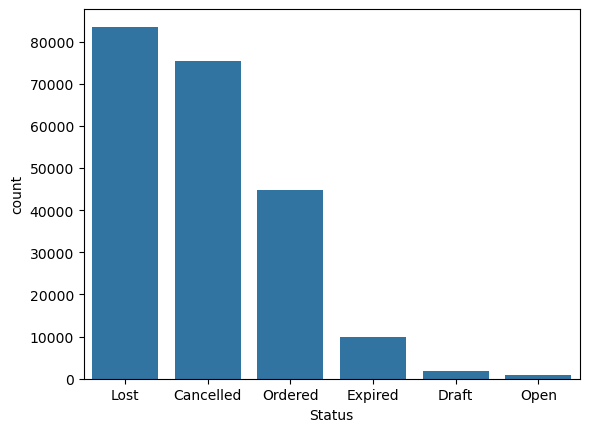

In [8]:
# Distribution of accepted vs. rejected quotations
sns.countplot(x='Status', data=df)
plt.show()

##### Data Cleaning

In [10]:
# Remove Cancelled and Draft Quotations
df1 = df[df['Docstatus'] == 1]

In [11]:
categories = df1['Status'].unique().tolist()
print(categories)

['Lost', 'Ordered', 'Expired', 'Open']


In [12]:
# Convert to datetime format
df['Creation'] = pd.to_datetime(df['Creation'], errors='coerce')
df['Modified'] = pd.to_datetime(df['Modified'], errors='coerce')

In [13]:
# Handle missing values
df1 = df1.fillna('Unknown')

In [14]:
from sklearn.preprocessing import LabelEncoder

# List of columns to encode
columns_to_encode = ['Customer Group', 'Payment Type', 'Department', 'Brand', 'Stock Uom', 'Status', 'Lost Reason', 'Item Group', 'Stocking Status','Item Vailability']

label_encoders = {}
for col in columns_to_encode:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le

In [15]:
print(df1.dtypes)

Name                             object
Creation                         object
Modified                         object
Docstatus                         int64
Customer Name                    object
Transaction Date                 object
Address Display                  object
Customer Group                    int32
Total Qty                       float64
Base Net Total                  float64
Base Total Taxes And Charges    float64
Base Grand Total                float64
Status                            int32
Payment Type                      int32
Total Cost ($)                  float64
Account Manager Name             object
Sales Manager Name               object
Department                        int32
Creation.1                       object
Modified.1                       object
Lost Reason                       int32
Item Code                        object
Item Name                        object
Item Group                        int32
Brand                             int32


##### Feature Engineering

###### Date Based Features

In [18]:
df1['Creation'] = pd.to_datetime(df1['Creation'])
df1['Modified'] = pd.to_datetime(df1['Modified'])

# Create new column with the difference in days
df1['Quotation_Duration'] = (df1['Modified'] - df1['Creation']).dt.days

###### Customer Behaviour Features

In [20]:
# Create a binary column for success-like statuses ('Open' or 'Ordered')
df1['Is_Loyal'] = df1['Status'].isin(['Open', 'Ordered']).astype(int)

# Group by 'Customer Name' and calculate sum and count
loyalty = df1.groupby('Customer Name').agg(
    Loyalty_Numerator=('Is_Loyal', 'sum'),
    Total_Quotations=('Name', 'count')  # Assuming 'Name' is the quotation ID or similar
).reset_index()

# Calculate the Customer Loyalty Score
loyalty['Customer_Loyalty_Score'] = loyalty['Loyalty_Numerator'] / loyalty['Total_Quotations']

# Merge back into original dataframe
df1 = df1.merge(loyalty[['Customer Name', 'Customer_Loyalty_Score']], on='Customer Name', how='left')

###### Financial Ratios

In [22]:
df1['Discount_Percentage'] = df1['Discount Amount ($)'] / df1['Price List Rate']
df1['Discount_Percentage'] = df1['Discount Amount ($)'] / df1['Price List Rate'].replace(0, pd.NA)

In [23]:
df1['Margin_Percentage'] = df1['Margin ($)'] / df1['Base Net Amount']
df1['Margin_Percentage'] = df1['Margin ($)'] / df1['Base Net Amount'].replace(0, pd.NA)

In [24]:
df1['Cost_to_Value_Ratio'] = df1['Item Cost ($)'] / df1['Base Net Amount']
df1['Cost_to_Value_Ratio'] = df1['Item Cost ($)'] / df1['Base Net Amount'].replace(0, pd.NA)

###### Item Features

In [26]:
# Create a success flag based on 'Status'
df1['Is_Success'] = df1['Status'].isin(['Open', 'Ordered']).astype(int)

# Group by Item Code and compute required metrics
item_grouped = df1.groupby('Item Code').agg(
    Average_Item_Discount=('Discount Amount ($)', 'mean'),
    Average_Item_Margin=('Margin ($)', 'mean'),
    Quotes_Won=('Is_Success', 'count'),
    Total_Quotes=('Name', 'count')  # Assuming 'Name' is quotation ID
).reset_index()

# Calculate success rate
item_grouped['Item_Success_Rate'] = item_grouped['Quotes_Won'] / item_grouped['Total_Quotes']

In [27]:
df1 = df1.merge(item_grouped[['Item Code', 'Average_Item_Discount', 'Average_Item_Margin', 'Item_Success_Rate']], 
                on='Item Code', how='left')

###### Manager / Department Based

In [29]:
df1['Account Manager Name'] = df1['Account Manager Name'].astype('category')
df1['Sales Manager Name'] = df1['Sales Manager Name'].astype('category')
df1['Department'] = df1['Department'].astype('category')

In [30]:
# Group by Account Manager
account_manager_perf = df1.groupby('Account Manager Name').agg(
    Total_Quotes=('Name', 'count'),
    Quotes_Won=('Is_Success', 'sum')
).reset_index()

account_manager_perf['Success_Rate'] = account_manager_perf['Quotes_Won'] / account_manager_perf['Total_Quotes']

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\719442807.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  account_manager_perf = df1.groupby('Account Manager Name').agg(


In [31]:
# Group by Sales Manager
sales_manager_perf = df1.groupby('Sales Manager Name').agg(
    Total_Quotes=('Name', 'count'),
    Quotes_Won=('Is_Success', 'sum')
).reset_index()

sales_manager_perf['Success_Rate'] = sales_manager_perf['Quotes_Won'] / sales_manager_perf['Total_Quotes']

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\1968315563.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_manager_perf = df1.groupby('Sales Manager Name').agg(


In [32]:
# Group by Department
dept_perf = df1.groupby('Department').agg(
    Total_Quotes=('Name', 'count'),
    Quotes_Won=('Is_Success', 'sum')
).reset_index()

dept_perf['Success_Rate'] = dept_perf['Quotes_Won'] / dept_perf['Total_Quotes']

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3881183125.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_perf = df1.groupby('Department').agg(


In [33]:
df1 = df1.merge(account_manager_perf[['Account Manager Name', 'Success_Rate']], on='Account Manager Name', how='left', suffixes=('', '_Manager'))

###### Stock & Availability

In [35]:
df1['Stock_Shortage'] = df1['Projected Qty'] - df1['Actual Qty']

In [36]:
df1['Stock_Shortage'] = df1['Projected Qty'].fillna(0) - df1['Actual Qty'].fillna(0)

##### Feature Extraction

In [38]:
pip install pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [39]:
df1.head()

,Name,Creation,Modified,Docstatus,Customer Name,Transaction Date,Address Display,Customer Group,Total Qty,Base Net Total,...,Customer_Loyalty_Score,Discount_Percentage,Margin_Percentage,Cost_to_Value_Ratio,Is_Success,Average_Item_Discount,Average_Item_Margin,Item_Success_Rate,Success_Rate,Stock_Shortage
0,SAL-QTN-2022-00021,2022-04-18 11:26:00,2022-08-29 08:40:00,1,Richard Peiris Tyre Co Ltd,6-Apr-22,"P O Box 16, Nawinna,<br>Maharagama<br>\nSri La...",7,5.0,8392.0,...,0.0,0.270968,0.012483,0.274281,0,1551.103684,29.510526,1.0,0.0,0.0
1,SAL-QTN-2022-00021,2022-04-18 11:26:00,2022-08-29 08:40:00,1,Richard Peiris Tyre Co Ltd,6-Apr-22,"P O Box 16, Nawinna,<br>Maharagama<br>\nSri La...",7,5.0,8392.0,...,0.0,0.273684,0.011654,0.549739,0,2755.487123,-68.306472,1.0,0.0,0.0
2,SAL-QTN-2022-00021,2022-04-18 11:26:00,2022-08-29 08:40:00,1,Richard Peiris Tyre Co Ltd,6-Apr-22,"P O Box 16, Nawinna,<br>Maharagama<br>\nSri La...",7,5.0,8392.0,...,0.0,0.27619,0.049068,0.276250,0,374.965796,32.872449,1.0,0.0,0.0
3,SAL-QTN-2022-00022,2022-04-18 12:59:00,2022-08-17 20:25:00,1,Srilankan Airlines Ltd,18-Apr-22,Unknown,0,2.0,7845.0,...,0.0,0.25,0.012112,0.533147,0,2633.625785,-120.563720,1.0,0.0,0.0
4,SAL-QTN-2022-00022,2022-04-18 12:59:00,2022-08-17 20:25:00,1,Srilankan Airlines Ltd,18-Apr-22,Unknown,0,2.0,7845.0,...,0.0,0.25,0.011719,0.532378,0,2755.487123,-68.306472,1.0,0.0,-1.0


In [41]:
df1.head()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139080 entries, 0 to 139079
Data columns (total 53 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Name                          139080 non-null  object        
 1   Creation                      139080 non-null  datetime64[ns]
 2   Modified                      139080 non-null  datetime64[ns]
 3   Docstatus                     139080 non-null  int64         
 4   Customer Name                 139080 non-null  object        
 5   Transaction Date              139080 non-null  object        
 6   Address Display               139080 non-null  object        
 7   Customer Group                139080 non-null  int32         
 8   Total Qty                     139080 non-null  float64       
 9   Base Net Total                139080 non-null  float64       
 10  Base Total Taxes And Charges  139080 non-null  float64       
 11  Base Grand To

#### Mutual Information for Feature Selection

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3772830455.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_results.head(top_n), x='MI Score', y='Feature', palette='viridis')


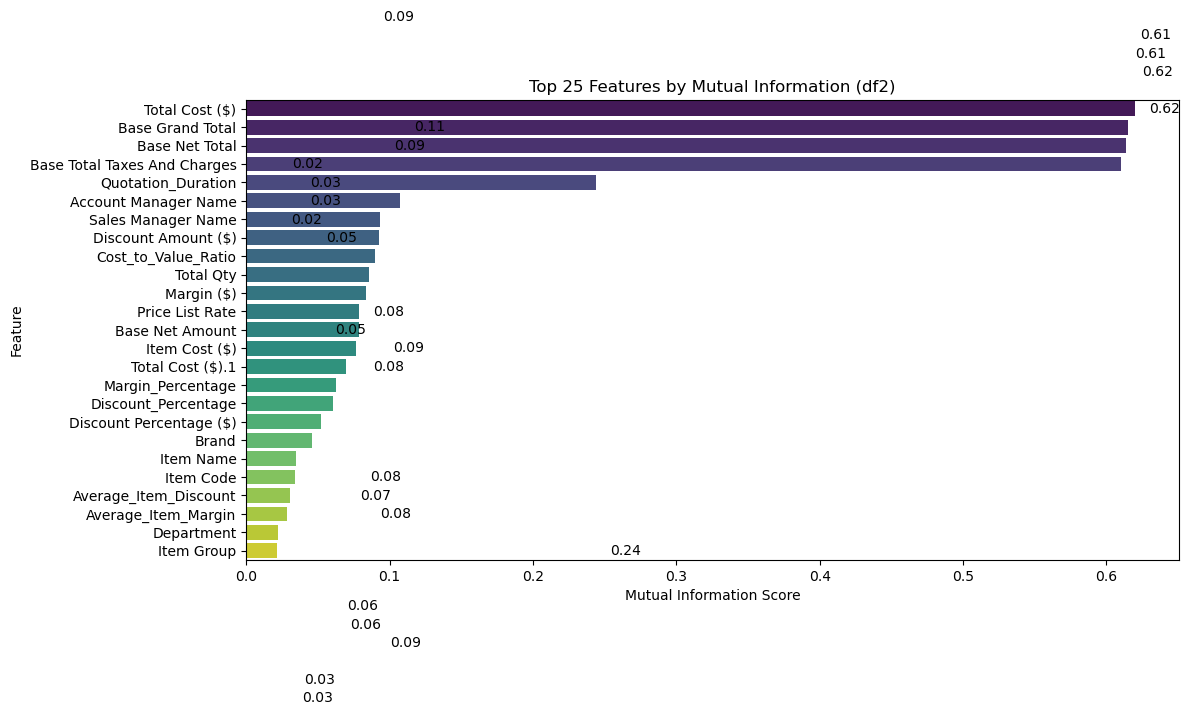

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Define irrelevant columns (metadata, IDs, timestamps)
irrelevant_cols = [
    'Name', 'Creation', 'Modified', 'Customer Name', 'Transaction Date',
    'Address Display', 'Creation.1', 'Modified.1', 'Lost Reason'
]

# Define engineered numeric columns (informative)
engineered_numeric_cols = [
    'quotation duration', 'customer loyalty score', 'discount percentage',
    'margin percentage', 'cost to value ratio', 'item success rate',
    'success rate', 'stock shortage'
]

# Create df2 by removing irrelevant columns from df1
df2 = df1.drop(columns=[col for col in irrelevant_cols if col in df1.columns])

# Convert engineered numeric columns to numeric in df2
for col in engineered_numeric_cols:
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Handle missing values
for col in df2.columns:
    if pd.api.types.is_numeric_dtype(df2[col]):
        df2[col] = df2[col].fillna(0)
    else:
        df2[col] = df2[col].astype(str).fillna('Unknown')

# Encode categorical features
label_encoders = {}
for col in df2.columns:
    if df2[col].dtype == 'object':
        le = LabelEncoder()
        df2[col] = le.fit_transform(df2[col])
        label_encoders[col] = le

# Separate target (status) and features in df2
target_col = 'Status'
if target_col not in df2.columns:
    raise KeyError(f"'{target_col}' column is not found in the dataset.")

y = df2[target_col]
X = df2.drop(columns=[target_col])

# Apply Mutual Information to df2
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X, y)
mi_scores = mi_selector.scores_

# Create score DataFrame for df2
mi_results = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

# Plot top N features from df2
top_n = 25
plt.figure(figsize=(12, 8))
sns.barplot(data=mi_results.head(top_n), x='MI Score', y='Feature', palette='viridis')
plt.title(f'Top {top_n} Features by Mutual Information (df2)')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')

# Add score labels on the bars
for index, row in mi_results.head(top_n).iterrows():
    plt.text(row['MI Score'] + 0.01, index - mi_results.head(top_n).index[0], f"{row['MI Score']:.2f}", va='center')

plt.tight_layout()
plt.show()

In [94]:
# Threshold value is 0.05
significant_features = mi_results[mi_results['MI Score'] > 0.05]['Feature'].tolist()
print("Significant features (MI Score > 0.05):")
print(significant_features)

Significant features (MI Score > 0.05):
['Total Cost ($)', 'Base Grand Total', 'Base Net Total', 'Base Total Taxes And Charges', 'Quotation_Duration', 'Account Manager Name', 'Sales Manager Name', 'Discount Amount ($)', 'Cost_to_Value_Ratio', 'Total Qty', 'Margin ($)', 'Price List Rate', 'Base Net Amount', 'Item Cost ($)', 'Total Cost ($).1', 'Margin_Percentage', 'Discount_Percentage', 'Discount Percentage ($)']


In [96]:
df2.head()

,Docstatus,Customer Group,Total Qty,Base Net Total,Base Total Taxes And Charges,Base Grand Total,Status,Payment Type,Total Cost ($),Account Manager Name,...,Customer_Loyalty_Score,Discount_Percentage,Margin_Percentage,Cost_to_Value_Ratio,Is_Success,Average_Item_Discount,Average_Item_Margin,Item_Success_Rate,Success_Rate,Stock_Shortage
0,1,7,5.0,8392.0,671.36,9063.36,1,1,4611.67,13,...,0.0,1694,0.012483,0.274281,0,1551.103684,29.510526,1.0,0.0,0.0
1,1,7,5.0,8392.0,671.36,9063.36,1,1,4611.67,13,...,0.0,1757,0.011654,0.549739,0,2755.487123,-68.306472,1.0,0.0,0.0
2,1,7,5.0,8392.0,671.36,9063.36,1,1,4611.67,13,...,0.0,1829,0.049068,0.276250,0,374.965796,32.872449,1.0,0.0,0.0
3,1,0,2.0,7845.0,627.60,8472.60,1,1,4179.47,23,...,0.0,1500,0.012112,0.533147,0,2633.625785,-120.563720,1.0,0.0,0.0
4,1,0,2.0,7845.0,627.60,8472.60,1,1,4179.47,23,...,0.0,1500,0.011719,0.532378,0,2755.487123,-68.306472,1.0,0.0,-1.0


#### Chi Suqare Test for Feature Selection

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3399528264.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


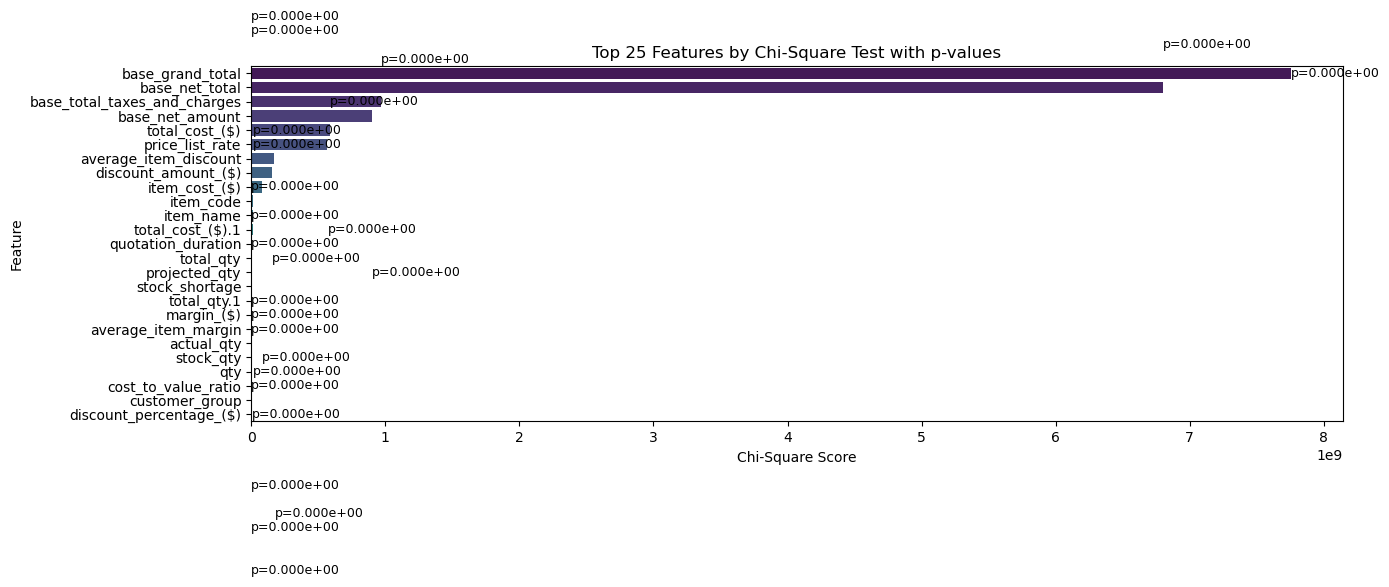

In [99]:
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make a copy of the original DataFrame
df3 = df1.copy()

# Filter only finalized quotations (docstatus = 1)
df3 = df3[df3['Docstatus'] == 1].copy()

# Drop irrelevant or text-heavy/date columns
drop_cols = [
    'Name', 'Creation', 'Modified', 'Customer Name', 'Transaction Date',
    'Address Display', 'Creation.1', 'Modified.1', 'Account Manager Name',
    'Sales Manager Name', 'Lost Reason'
]
df3 = df3.drop(columns=drop_cols, errors='ignore')

# Clean column names
df3.columns = df3.columns.str.strip().str.lower().str.replace(' ', '_')

# Define features and target
if 'status' in df3.columns:
    y = df3['status']
    X = df3.drop(columns=['status'])
else:
    raise KeyError("The target column 'status' was not found in the DataFrame.")

# Convert to numeric and clip negative values
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
X = X.clip(lower=0)

# Apply Chi-Square Feature Selection
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X, y)

# Extract scores and p-values
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

# Create DataFrame with scores and p-values
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': chi2_pvalues
}).sort_values(by='Chi2 Score', ascending=False)

# Plot the top N features
top_n = 25
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=chi2_results.head(top_n),
    x='Chi2 Score',
    y='Feature',
    palette='viridis'
)

# Annotate bars with p-values
for i, row in chi2_results.head(top_n).iterrows():
    p_val = f"{row['p-value']:.3e}"  # scientific notation
    ax.text(
        row['Chi2 Score'] + 0.5,
        i - chi2_results.head(top_n).index[0],
        f"p={p_val}",
        va='center',
        fontsize=9,
        color='black'
    )

plt.title(f'Top {top_n} Features by Chi-Square Test with p-values')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [101]:
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': chi2_pvalues
}).sort_values(by='Chi2 Score', ascending=False)


In [103]:
# P-Value < 0.05 features, threshold value is 0.05
print(chi2_results.head())

                         Feature    Chi2 Score  p-value
5               base_grand_total  7.753636e+09      0.0
3                 base_net_total  6.800454e+09      0.0
4   base_total_taxes_and_charges  9.689807e+08      0.0
19               base_net_amount  9.003847e+08      0.0
7                 total_cost_($)  5.880088e+08      0.0


##### Both the Chi-Square test and the Mutual Information method yielded similar results in terms of feature importance. The commonly selected features from both tests are as follows:  

Total Cost, Base Grand Total, Base Net Total, Base Total Taxes And Charges, Quotation Duration, Account Manager Name, Sales Manager Name, Discount Amount, Cost to Value Ratio, Total Qty, Margin, Price List Rate, Base Net Amount, Item Cost.1, Margin Percentage, Discount Percentage, Discount Percentage($) 

#### Machine Learning Models Application for Predict the Quotation Success

In [124]:
# Define the list of columns you want to keep
selected_columns = [
    'Status', 'Total Cost ($)', 'Base Grand Total', 'Base Net Total', 'Base Total Taxes And Charges',
    'Quotation_Duration', 'Account Manager Name', 'Sales Manager Name', 'Discount Amount ($)',
    'Cost_to_Value_Ratio', 'Total Qty', 'Margin ($)', 'Price List Rate', 'Base Net Amount',
    'Item Cost ($)', 'Total Cost ($).1', 'Margin_Percentage', 'Discount_Percentage', 'Discount Percentage ($)'
]

# Filter df2 to keep only those columns (if they exist)
df4 = df2[[col for col in selected_columns if col in df2.columns]].copy()

In [126]:
# Filtered dataset
df4.head()

,Status,Total Cost ($),Base Grand Total,Base Net Total,Base Total Taxes And Charges,Quotation_Duration,Account Manager Name,Sales Manager Name,Discount Amount ($),Cost_to_Value_Ratio,Total Qty,Margin ($),Price List Rate,Base Net Amount,Item Cost ($),Total Cost ($).1,Margin_Percentage,Discount_Percentage,Discount Percentage ($)
0,1,4611.67,9063.36,8392.0,671.36,132,13,1,672.0,0.274281,5.0,45.14,2480.0,3616.0,991.80,1983.60,0.012483,1694,27.10
1,1,4611.67,9063.36,8392.0,671.36,132,13,1,1456.0,0.549739,5.0,45.03,5320.0,3864.0,2124.19,2124.19,0.011654,1757,27.37
2,1,4611.67,9063.36,8392.0,671.36,132,13,1,174.0,0.276250,5.0,44.75,630.0,912.0,251.94,503.88,0.049068,1829,27.62
3,1,4179.47,8472.60,7845.0,627.60,121,23,12,1285.0,0.533147,2.0,46.69,5140.0,3855.0,2055.28,2055.28,0.012112,1500,25.00
4,1,4179.47,8472.60,7845.0,627.60,121,23,12,1330.0,0.532378,2.0,46.76,5320.0,3990.0,2124.19,2124.19,0.011719,1500,25.00


#### Logistic Regression

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [133]:
# Ensure target column exists
if 'Status' not in df4.columns:
    raise KeyError("'Status' column not found in df4")

# Separate features and target
X = df4.drop(columns=['Status'])
y = df4['Status']

# Encode target if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)  # Now y will be 0s and 1s

In [135]:
# Fill numeric NaNs with 0
X = X.fillna(0)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
model.fit(X_train, y_train)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [143]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
import numpy as np

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# RMSE Calculation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4f}")


Confusion Matrix:
[[    2  1958     0     0]
 [   20 16722     1    29]
 [    2   170     0     0]
 [    3  8897     0    12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.00      0.00      1960
           1       0.60      1.00      0.75     16772
           2       0.00      0.00      0.00       172
           3       0.29      0.00      0.00      8912

    accuracy                           0.60     27816
   macro avg       0.24      0.25      0.19     27816
weighted avg       0.46      0.60      0.45     27816


Accuracy Score:
0.6016681046879494

Root Mean Squared Error (RMSE): 1.1671


#### Decision Tree Classifier

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [148]:
# Ensure the 'Status' column exists
if 'Status' not in df4.columns:
    raise KeyError("'Status' column not found in df4")

# Separate features and target
X = df4.drop(columns=['Status'])
y = df4['Status']

# Encode target if categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

In [150]:
# Fill numeric missing values with 0
X = X.fillna(0)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [156]:
# Make predictions
y_pred = dt_model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy Score
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4f}")

Confusion Matrix:
[[ 1636    39    12   273]
 [   66 15403     3  1300]
 [   16     2   117    37]
 [  293  1412    49  7158]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1960
           1       0.91      0.92      0.92     16772
           2       0.65      0.68      0.66       172
           3       0.82      0.80      0.81      8912

    accuracy                           0.87     27816
   macro avg       0.80      0.81      0.80     27816
weighted avg       0.87      0.87      0.87     27816


Accuracy Score:
0.8741012366983031

Root Mean Squared Error (RMSE): 0.7643


#### Random Forest Classifier

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

In [161]:
# Ensure target column exists
if 'Status' not in df4.columns:
    raise KeyError("'Status' column not found in df4")

# Separate features and target
X = df4.drop(columns=['Status'])
y = df4['Status']

# Encode target if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

In [163]:
X = X.fillna(0)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [169]:
y_pred = rf_model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy Score
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4f}")

Confusion Matrix:
[[ 1585    48     1   326]
 [   27 16215     0   530]
 [   16     1    97    58]
 [  156  1784     5  6967]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1960
           1       0.90      0.97      0.93     16772
           2       0.94      0.56      0.71       172
           3       0.88      0.78      0.83      8912

    accuracy                           0.89     27816
   macro avg       0.90      0.78      0.83     27816
weighted avg       0.89      0.89      0.89     27816


Accuracy Score:
0.8938740293356342

Root Mean Squared Error (RMSE): 0.7044


In [171]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
                         Feature  Importance
4             Quotation_Duration    0.245722
3   Base Total Taxes And Charges    0.064705
0                 Total Cost ($)    0.064340
2                 Base Net Total    0.063230
1               Base Grand Total    0.062549
9                      Total Qty    0.061147
6             Sales Manager Name    0.058262
5           Account Manager Name    0.046496
10                    Margin ($)    0.044928
16           Discount_Percentage    0.038274
17       Discount Percentage ($)    0.036297
8            Cost_to_Value_Ratio    0.035762
12               Base Net Amount    0.032154
15             Margin_Percentage    0.031544
7            Discount Amount ($)    0.030241
11               Price List Rate    0.029458
14              Total Cost ($).1    0.028612
13                 Item Cost ($)    0.026279


In [173]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

#### Support Vector Machine Application

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

In [178]:
# Check if 'Status' is in df4
if 'Status' not in df4.columns:
    raise KeyError("'Status' column is not found in df4.")

# Separate features and target
X = df4.drop(columns=['Status'])
y = df4['Status']

# Encode target if it's categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

In [180]:
# Fill missing values
X = X.fillna(0)

# Scale features (SVM performs better with scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [184]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [186]:
# Make predictions
y_pred = svm_model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy Score
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4f}")

Confusion Matrix:
[[  452   813     0   695]
 [  101 15181     0  1490]
 [    4    87     0    81]
 [  199  5636     0  3077]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.23      0.33      1960
           1       0.70      0.91      0.79     16772
           2       0.00      0.00      0.00       172
           3       0.58      0.35      0.43      8912

    accuracy                           0.67     27816
   macro avg       0.47      0.37      0.39     27816
weighted avg       0.65      0.67      0.64     27816


Accuracy Score:
0.6726344549899339

Root Mean Squared Error (RMSE): 1.1634


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Train a Random Forest Model for Predict the Quotation Lost Reason

In [197]:
categories = df1['Lost Reason'].unique().tolist()
print(categories)

[11, 1, 12, 2, 10, 3, 9, 0, 6, 8, 7, 4, 5]


In [219]:
# Define the list of columns you want to keep
selected_columns = [
    'Status', 'Total Cost ($)', 'Base Grand Total', 'Base Net Total', 'Base Total Taxes And Charges',
    'Quotation_Duration', 'Account Manager Name', 'Sales Manager Name', 'Discount Amount ($)',
    'Cost_to_Value_Ratio', 'Total Qty', 'Margin ($)', 'Price List Rate', 'Base Net Amount',
    'Item Cost ($)', 'Total Cost ($).1', 'Margin_Percentage', 'Discount Percentage ($)', 'Lost Reason'
]

# Filter df2 to keep only those columns (if they exist)
df5 = df1[[col for col in selected_columns if col in df1.columns]].copy()

In [221]:
from sklearn.preprocessing import LabelEncoder

# Create label encoders
le_account = LabelEncoder()
le_sales = LabelEncoder()

# Apply label encoding
df5['Account Manager Name'] = le_account.fit_transform(df5['Account Manager Name'].astype(str))
df5['Sales Manager Name'] = le_sales.fit_transform(df5['Sales Manager Name'].astype(str))

In [223]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [225]:
# Copy the dataset
data = df5.copy()

# Check if 'Lost Reason' column is present
if 'Lost Reason' not in data.columns:
    raise KeyError("'Lost Reason' column is not found in df5.")

# Separate target and features
y = data['Lost Reason']
X = data.drop(columns=['Lost Reason'])

# Encode categorical columns
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Encode target (Lost Reason)
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y.astype(str))

In [227]:
# Fill missing values (if any)
X = X.fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [229]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [231]:
y_pred = model.predict(X_test)

# Inverse transform to get original lost reason labels
y_test_labels = target_encoder.inverse_transform(y_test)
y_pred_labels = target_encoder.inverse_transform(y_pred)

# Print evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

print("\nAccuracy Score:")
print(accuracy_score(y_test_labels, y_pred_labels))

Confusion Matrix:
[[    2     0     0     0     0     0     1     0     0     0     0     0
      0]
 [    0   747     2    28    18     8   114     0     0     4     0     0
      0]
 [    0     7   621    72    52     9   116     0     0     4     0     0
      5]
 [    0    23    25 15902   131    20   257     2     0     1     1     1
      3]
 [    0    31    30   143  2569    75   496     3     0     8     5     1
      4]
 [    0    16    22    59   166   488   157     0     0     3     2     0
      6]
 [    0   123    66   199   409    42  3451     1     0    16     1     5
      3]
 [    0     0     0     1     7     2    29    74     0     0     1     2
      0]
 [    0     0     0     2     5     2    17     3    48     1     1     2
      0]
 [    0     1     2     3     5     7    26     0     0   205     1     0
     11]
 [    0     0     0     1    16     1    11     1     1     0    91     1
      1]
 [    0     0     4     2    28     2    36     3     1     2     1  

#### Optimize the Quotation Success

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\347844743.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Lost Reason', order=df['Lost Reason'].value_counts().index, palette='magma')


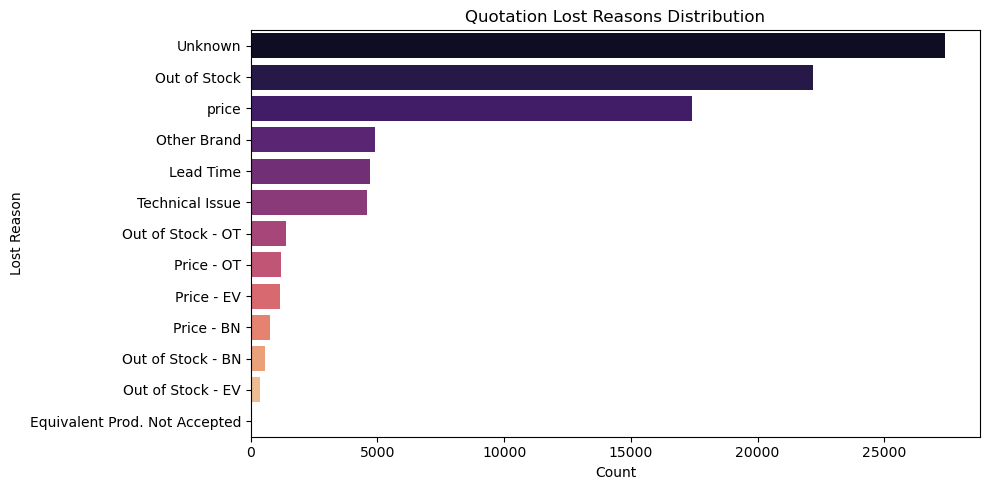

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot frequency of each lost reason
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='Lost Reason', order=df['Lost Reason'].value_counts().index, palette='magma')
plt.title('Quotation Lost Reasons Distribution')
plt.xlabel('Count')
plt.ylabel('Lost Reason')
plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\1774164746.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df5, y='Lost Reason', order=df5['Lost Reason'].value_counts().index, palette='magma')


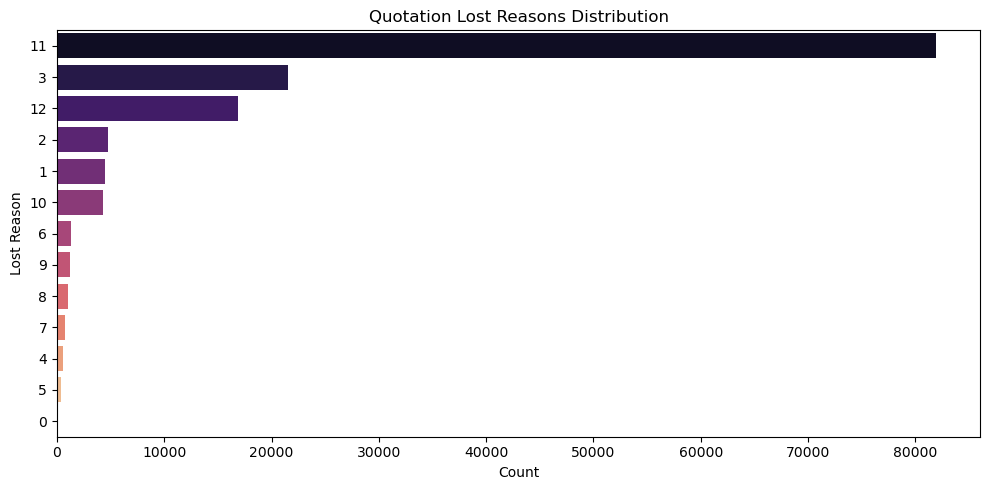

In [263]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot frequency of each lost reason
plt.figure(figsize=(10, 5))
sns.countplot(data=df5, y='Lost Reason', order=df5['Lost Reason'].value_counts().index, palette='magma')
plt.title('Quotation Lost Reasons Distribution')
plt.xlabel('Count')
plt.ylabel('Lost Reason')
plt.tight_layout()
plt.show()

#### Lost Reason is Out of Stock

In [278]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139080 entries, 0 to 139079
Data columns (total 53 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Name                          139080 non-null  object        
 1   Creation                      139080 non-null  datetime64[ns]
 2   Modified                      139080 non-null  datetime64[ns]
 3   Docstatus                     139080 non-null  int64         
 4   Customer Name                 139080 non-null  object        
 5   Transaction Date              139080 non-null  object        
 6   Address Display               139080 non-null  object        
 7   Customer Group                139080 non-null  int32         
 8   Total Qty                     139080 non-null  float64       
 9   Base Net Total                139080 non-null  float64       
 10  Base Total Taxes And Charges  139080 non-null  float64       
 11  Base Grand To

In [288]:
out_of_stock_df = df1[df1['Lost Reason'] == 3]

In [290]:
# Replace 'Item Name' with your actual item column
item_stock_issue_counts = out_of_stock_df.groupby('Item Name').size().reset_index(name='Out of Stock Count')

# Sort by highest impact
item_stock_issue_counts = item_stock_issue_counts.sort_values(by='Out of Stock Count', ascending=False)

# Show top 10 problematic items
print(item_stock_issue_counts.head(10))

         Item Name  Out of Stock Count
1604  Others Sales                 651
90        A9N16204                 274
158       A9N4P63C                 210
1361      LV429387                 204
156       A9N4P32C                 195
100       A9N16255                 192
1142      LC1D09P7                 178
115       A9N1P16C                 169
157       A9N4P40C                 168
134       A9N2P32C                 167


C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\1171883274.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=item_stock_issue_counts.head(15), x='Out of Stock Count', y='Item Name', palette='rocket')


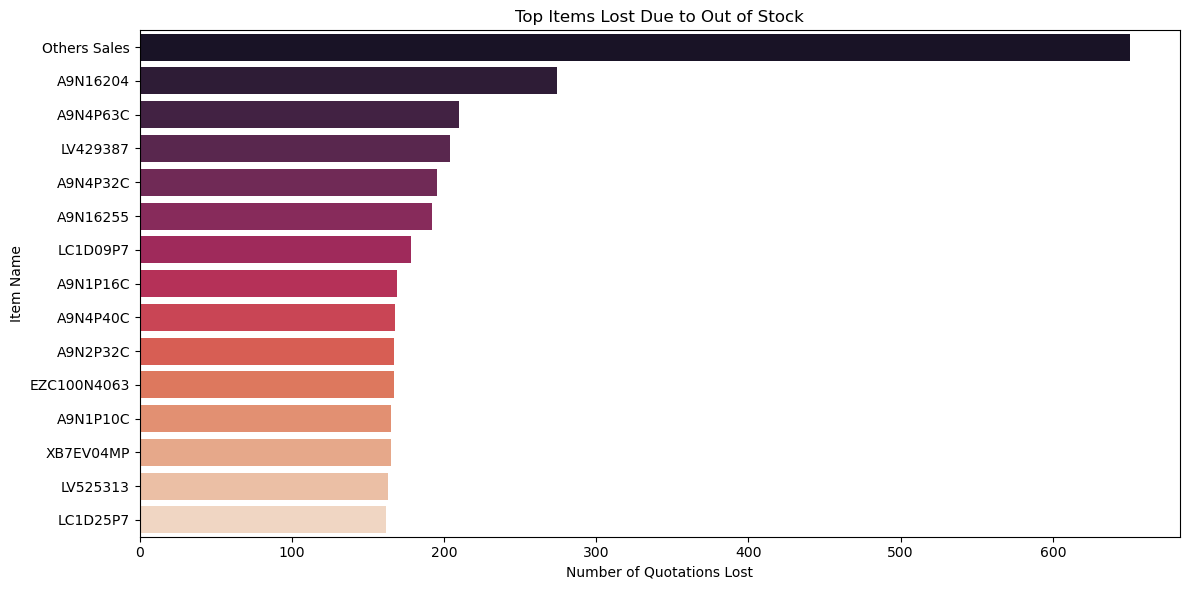

In [292]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=item_stock_issue_counts.head(15), x='Out of Stock Count', y='Item Name', palette='rocket')
plt.title('Top Items Lost Due to Out of Stock')
plt.xlabel('Number of Quotations Lost')
plt.ylabel('Item Name')
plt.tight_layout()
plt.show()

#### Lost Reason is Price

In [301]:
price_lost_df = df1[df1['Lost Reason'] == 12]

In [303]:
customer_price_loss = price_lost_df.groupby('Customer Name').size().reset_index(name='Lost Due to Price')

# Sort descending
customer_price_loss = customer_price_loss.sort_values(by='Lost Due to Price', ascending=False)

# Display top customers
print(customer_price_loss.head(10))

                                Customer Name  Lost Due to Price
99                          CASH SALE - OMESH                551
51                    Ansell Lanka (Pvt) Ltd.                366
133                       Cash Sales-Buddhika                343
461  Maliban Biscuit Manufactories (Pvt) Ltd.                249
539                  Ocean Lanka ( Pvt ) Ltd.                238
431                        Linaya Enterprises                227
105        CBL Foods International (Pvt) Ltd.                215
705               South Asia Textiles Limited                204
294        Global Rubber Industries (Pvt) Ltd                196
238        Earthfoam (Pvt) Ltd.\t\t\t\t\t\t\t                189


In [307]:
# Calculate average discount per customer
if 'Discount_Percentage' in df1.columns:
    avg_discount = price_lost_df.groupby('Customer Name')['Discount_Percentage'].mean().reset_index(name='Avg Discount (%)')

    # Merge with lost count
    customer_discount_analysis = pd.merge(customer_price_loss, avg_discount, on='Customer Name')

    # Prioritize: High loss count and low discount
    customer_discount_analysis['Priority Score'] = customer_discount_analysis['Lost Due to Price'] / (customer_discount_analysis['Avg Discount (%)'] + 1)
    
    # Sort by priority
    top_customers_to_incentivize = customer_discount_analysis.sort_values(by='Priority Score', ascending=False)

    print(top_customers_to_incentivize.head(10))

                               Customer Name  Lost Due to Price  \
0                          CASH SALE - OMESH                551   
1                    Ansell Lanka (Pvt) Ltd.                366   
2                        Cash Sales-Buddhika                343   
3   Maliban Biscuit Manufactories (Pvt) Ltd.                249   
4                   Ocean Lanka ( Pvt ) Ltd.                238   
5                         Linaya Enterprises                227   
6         CBL Foods International (Pvt) Ltd.                215   
8         Global Rubber Industries (Pvt) Ltd                196   
7                South Asia Textiles Limited                204   
13           Macksons Tiles Lanka (Pvt) Ltd.                163   

   Avg Discount (%) Priority Score  
0          0.281319     430.025592  
1          0.264057      289.54385  
2          0.287791     266.347478  
3          0.309438     190.157951  
4          0.315572     180.909896  
5          0.299427     174.692342  
6  

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3994627200.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=customer_price_loss.head(10), x='Lost Due to Price', y='Customer Name', palette='flare')
C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3994627200.py:9: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


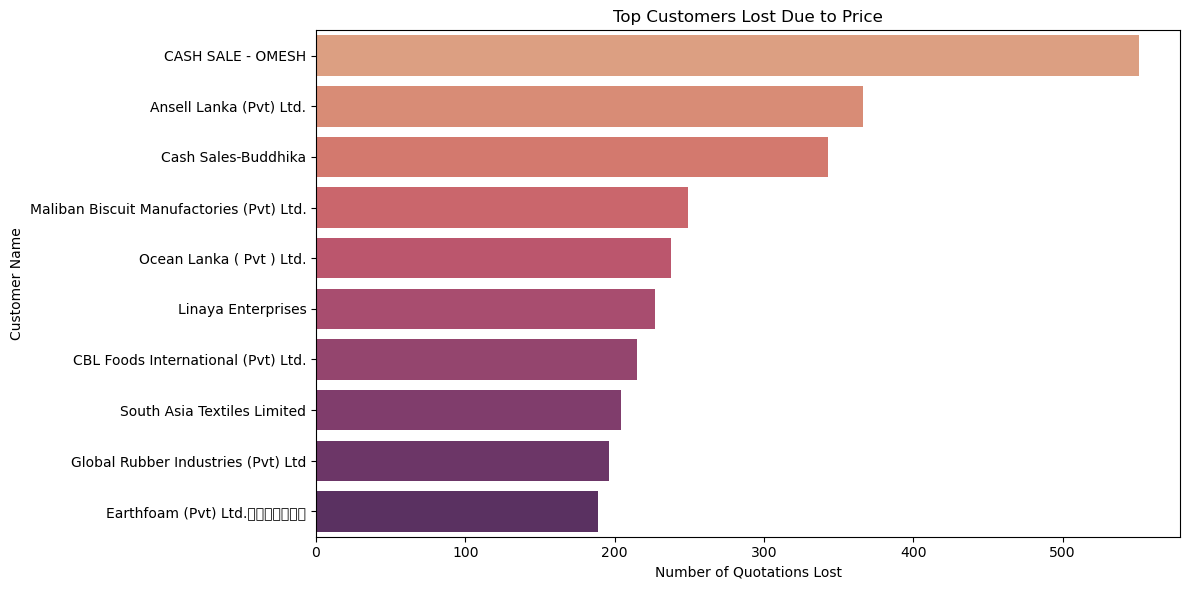

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=customer_price_loss.head(10), x='Lost Due to Price', y='Customer Name', palette='flare')
plt.title('Top Customers Lost Due to Price')
plt.xlabel('Number of Quotations Lost')
plt.ylabel('Customer Name')
plt.tight_layout()
plt.show()

#### Lost Reason is Other Brand

In [311]:
lost_other_brand_df = df1[df1['Lost Reason'] == 2]

In [315]:
# Replace 'Item Name' with your actual item column
item_loss_counts = lost_other_brand_df.groupby('Item Name').size().reset_index(name='Lost to Other Brand Count')

# Sort items by how often they were lost
item_loss_counts = item_loss_counts.sort_values(by='Lost to Other Brand Count', ascending=False)

# Show top items
print(item_loss_counts.head(10))

         Item Name  Lost to Other Brand Count
812   Others Sales                        142
51        A9N16204                         83
68        A9N1P10C                         69
69        A9N1P16C                         58
599       LC1D09P7                         54
82        A9N2P32C                         52
100       A9N4P63C                         45
67        A9N1P06C                         44
99        A9N4P40C                         44
1082     XB7EV04MP                         43


C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\1644730766.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=item_loss_counts.head(10), x='Lost to Other Brand Count', y='Item Name', palette='crest')


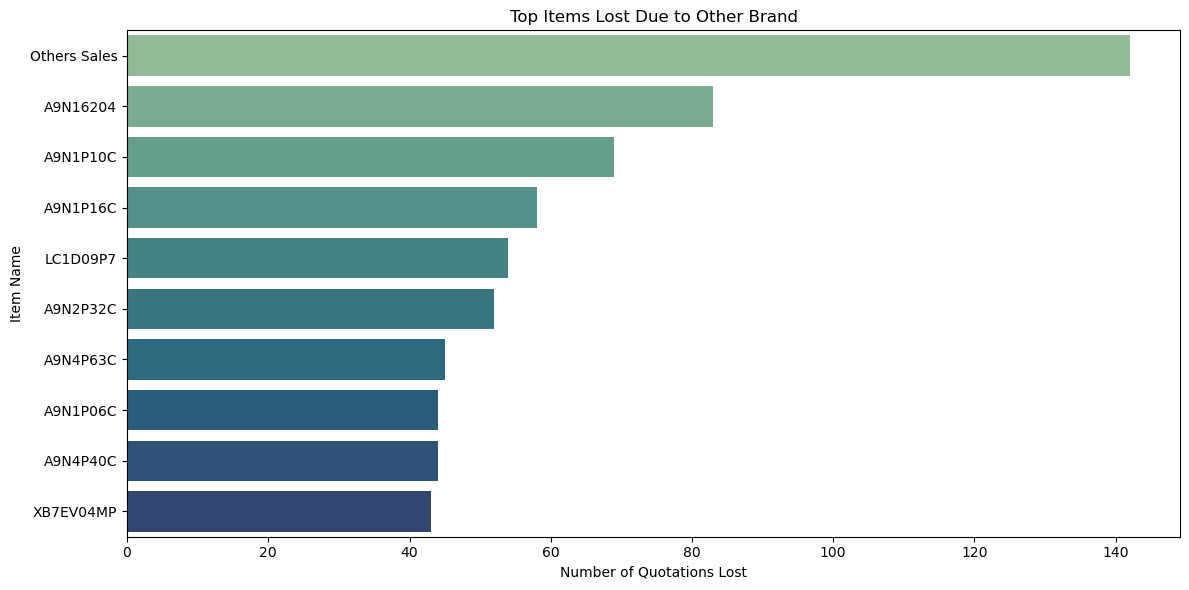

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=item_loss_counts.head(10), x='Lost to Other Brand Count', y='Item Name', palette='crest')
plt.title('Top Items Lost Due to Other Brand')
plt.xlabel('Number of Quotations Lost')
plt.ylabel('Item Name')
plt.tight_layout()
plt.show()

#### Lost Reason is Lead Time

In [321]:
lead_time_lost_df = df1[df1['Lost Reason'] == 1]

In [323]:
# Group by Account Manager
account_manager_counts = lead_time_lost_df.groupby('Account Manager Name').size().reset_index(name='Lost Due to Lead Time')

# Group by Sales Manager
sales_manager_counts = lead_time_lost_df.groupby('Sales Manager Name').size().reset_index(name='Lost Due to Lead Time')

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3775997522.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  account_manager_counts = lead_time_lost_df.groupby('Account Manager Name').size().reset_index(name='Lost Due to Lead Time')
C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3775997522.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_manager_counts = lead_time_lost_df.groupby('Sales Manager Name').size().reset_index(name='Lost Due to Lead Time')


In [329]:
# Sort descending
account_manager_counts = account_manager_counts.sort_values(by='Lost Due to Lead Time', ascending=False)
sales_manager_counts = sales_manager_counts.sort_values(by='Lost Due to Lead Time', ascending=False)

print("Top Account Managers with Lead Time Losses:")
print(account_manager_counts.head(3))

print("\nTop Sales Managers with Lead Time Losses:")
print(sales_manager_counts.head(3))

Top Account Managers with Lead Time Losses:
   Account Manager Name  Lost Due to Lead Time
31         Suresh Kumar                   2927
2     Bala Subramaniyam                    420
13       Jayalath Kamal                    326

Top Sales Managers with Lead Time Losses:
      Sales Manager Name  Lost Due to Lead Time
12      Pradeep Chaminda                   2402
1        Anoja Vithanage                    837
4   Chathuranga Sanjeewa                    748


C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\138199716.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=account_manager_counts.head(3), x='Lost Due to Lead Time', y='Account Manager Name', palette='rocket')


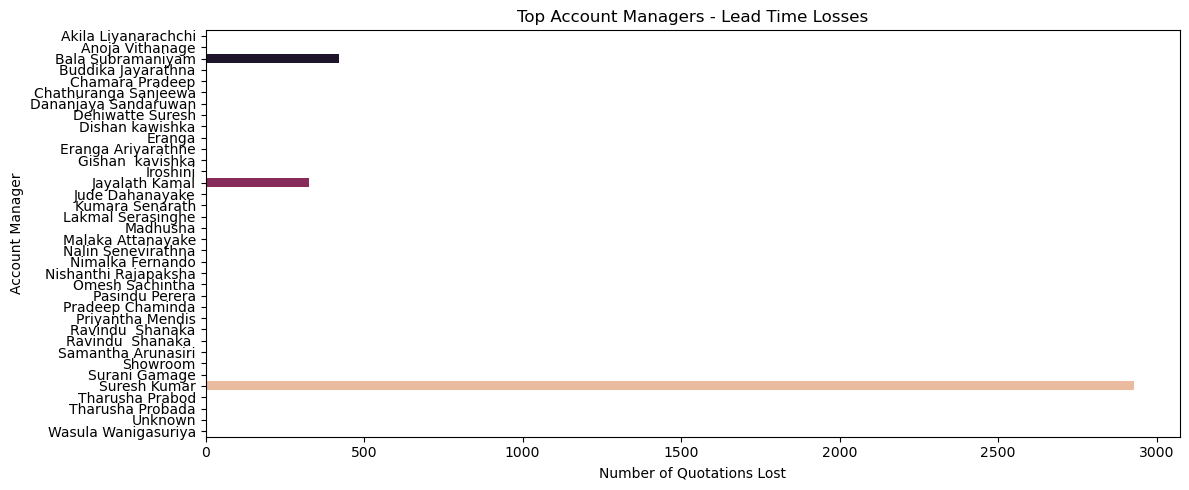

C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\138199716.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_manager_counts.head(3), x='Lost Due to Lead Time', y='Sales Manager Name', palette='mako')


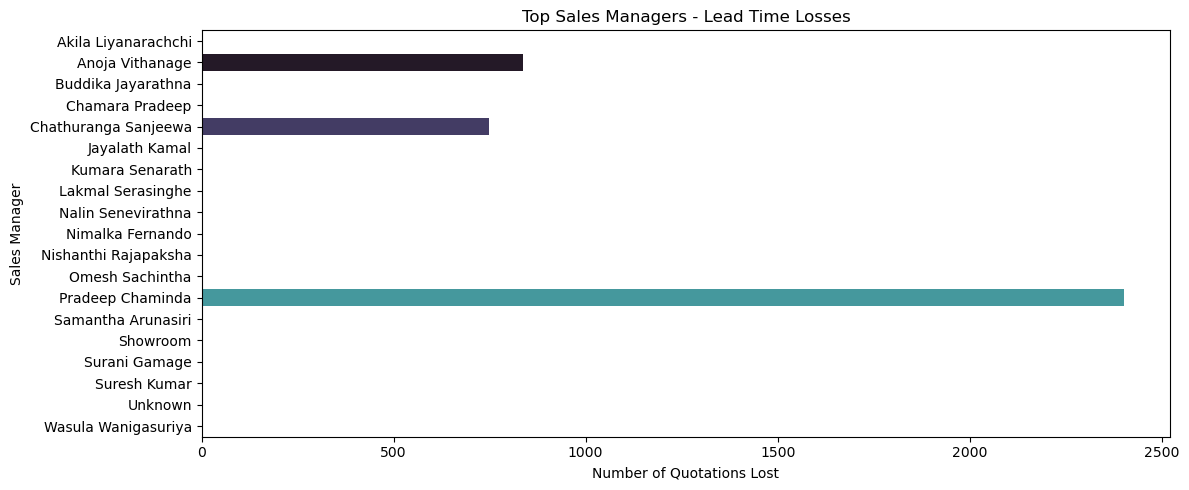

In [331]:
import seaborn as sns
import matplotlib.pyplot as plt

# Account Managers
plt.figure(figsize=(12, 5))
sns.barplot(data=account_manager_counts.head(3), x='Lost Due to Lead Time', y='Account Manager Name', palette='rocket')
plt.title('Top Account Managers - Lead Time Losses')
plt.xlabel('Number of Quotations Lost')
plt.ylabel('Account Manager')
plt.tight_layout()
plt.show()

# Sales Managers
plt.figure(figsize=(12, 5))
sns.barplot(data=sales_manager_counts.head(3), x='Lost Due to Lead Time', y='Sales Manager Name', palette='mako')
plt.title('Top Sales Managers - Lead Time Losses')
plt.xlabel('Number of Quotations Lost')
plt.ylabel('Sales Manager')
plt.tight_layout()
plt.show()

#### Lost Reason is Technical Issue

In [334]:
tech_issues_df = df1[df1['Lost Reason'] == 10]

In [336]:
# Group by customer
customer_issues = tech_issues_df.groupby('Customer Name').size().reset_index(name='Tech Issue Loss Count')

# Sort in descending order
customer_issues = customer_issues.sort_values(by='Tech Issue Loss Count', ascending=False)

# View top customers
print(customer_issues.head(10))

                               Customer Name  Tech Issue Loss Count
68                        Cash Sales-Pasindu                    672
142       Global Rubber Industries (Pvt) Ltd                    198
321             Teclan Engineering (Pvt) Ltd                    177
294            Siam City Cement (Lanka) Ltd.                    159
23          Ansell Textiles Lanka (Pvt) Ltd.                    134
86         Cool Man Refrigeration (Pvt) Ltd.                    110
281                 S M T Apparel Lanka Ltd.                     99
16           Airport & Aviation (Katunayaka)                     90
297  Silvermill Natural Beverages (Pvt) Ltd.                     86
148                            HSK Solutions                     82


C:\Users\DELL\AppData\Local\Temp\ipykernel_5148\3799313934.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=customer_issues.head(10), x='Tech Issue Loss Count', y='Customer Name', palette='flare')


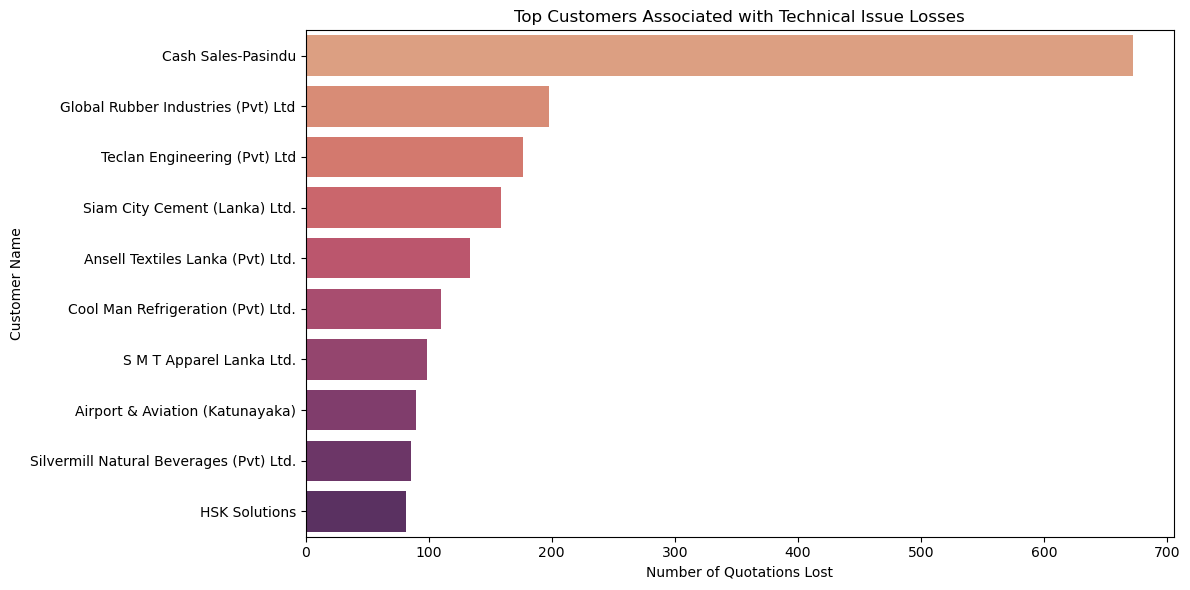

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=customer_issues.head(10), x='Tech Issue Loss Count', y='Customer Name', palette='flare')
plt.title('Top Customers Associated with Technical Issue Losses')
plt.xlabel('Number of Quotations Lost')
plt.ylabel('Customer Name')
plt.tight_layout()
plt.show()

#### Put Weights on Attributes to Quotation Success

In [444]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Step 1: Define your feature columns and target
features = [
    'Total Cost ($)', 'Base Grand Total', 'Base Net Total', 'Base Total Taxes And Charges',
    'Quotation_Duration', 'Account Manager Name', 'Sales Manager Name', 'Discount Amount ($)',
    'Cost_to_Value_Ratio', 'Total Qty', 'Margin ($)', 'Price List Rate', 'Base Net Amount',
    'Item Cost ($)', 'Total Cost ($).1', 'Margin_Percentage', 'Discount Percentage ($)'
]

target = 'Status'

# Step 2: Preprocess the data
df_encoded = df5.copy()

# Convert features to numeric (including handling categorical features)
for col in features:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    else:
        df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce').fillna(0)

# Encode target if it's not numeric
if df_encoded[target].dtype == 'object':
    df_encoded[target] = LabelEncoder().fit_transform(df_encoded[target].astype(str))

# Step 3: Train Random Forest to get feature importances
X = df_encoded[features]
y = df_encoded[target]

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Step 4: Extract and display feature importances (as weights)
importances = model.feature_importances_
feature_weights = pd.DataFrame({
    'Feature': features,
    'Weight': importances
}).sort_values(by='Weight', ascending=False)

# Normalize weights to make them percentages (optional)
feature_weights['Weight (%)'] = feature_weights['Weight'] * 100

# Show result
print(feature_weights)

                         Feature    Weight  Weight (%)
4             Quotation_Duration  0.254263   25.426305
0                 Total Cost ($)  0.069316    6.931554
3   Base Total Taxes And Charges  0.068442    6.844167
2                 Base Net Total  0.066573    6.657344
9                      Total Qty  0.065399    6.539893
1               Base Grand Total  0.065165    6.516454
6             Sales Manager Name  0.055839    5.583906
16       Discount Percentage ($)  0.049108    4.910764
5           Account Manager Name  0.048420    4.842042
10                    Margin ($)  0.046495    4.649502
8            Cost_to_Value_Ratio  0.035123    3.512280
12               Base Net Amount  0.031911    3.191072
7            Discount Amount ($)  0.031509    3.150890
15             Margin_Percentage  0.030707    3.070725
11               Price List Rate  0.028923    2.892306
14              Total Cost ($).1  0.027347    2.734654
13                 Item Cost ($)  0.025461    2.546140
